# EODC Dask Tutorial

Dask is a flexible parallel computing library for analytics that enables you to
scale your computations from a single machine to a cluster. This tutorial will
guide you through the basics of using Dask on the EODC cluster. The computation
will take place on the cluster and you only need to download the result to your
local machine for visualisation or further processing steps. As input data
for this tutorial we will use output data from the Global Flood Monitoring (GFM)
service. 

As an example, we will calculate the maximum flood extent of a certain time range
over an area of interest in Pakistan. 

## Prerequisites

Before we start, make sure you have installed all the necessary Python libraries and
packages with the correct versions. It is important that the cluster and client
(your machine) have the same versions for the key Python libraries. The easiest
way is to create a new Python environment with the package manager of your liking.
See the required dependencies in the [EODC cluster image](https://github.com/eodcgmbh/cluster_image) repository.

In order to spin up a dedicated cluster on the EODC cluster, you will need to
request an EODC account. Please follow the instructions [here](https://docs.eodc.eu/services/dask.html#who-should-use-dask-gateway-at-eodc).

## First some imports

In [ ]:
import pyproj
import rioxarray
import xarray as xr
from datetime import datetime
from shapely.geometry import box
from pystac_client import Client
from odc import stac as odc_stac
import matplotlib.pyplot as plt

from eodc import settings
from eodc.dask import EODCDaskGateway

settings.DASK_URL = "http://dask.services.eodc.eu"
settings.DASK_URL_TCP = "tcp://dask.services.eodc.eu:80/"

## Initialize cluster

Your username of your EODC account come here, usually it is your email address
you have used for registration. 
After running the next cell, a prompt will open and ask you to enter your
password. 

In [ ]:
your_username = "your.email@address.com"
gateway = EODCDaskGateway(username=your_username)

Once authenticated, you can specify the details of your cluster. Specify the
number of cores and size of memory of your worker machines. 
Additionally, you can specify any public docker image which has the same dask
version installed like our Dask cluster. However, we suggest you are using our
cluster image to avoid errors coming from mismatching software versions.

You will find more detailed information about dask
[here](https://docs.eodc.eu/services/dask.html).

The client object provides you with an URL to the dashboard of your current
cluster. Copy/paste this into your Firefox browser to get an overview what is
currently happening on your cluster.

In [ ]:
# Define cluster options
cluster_options = gateway.cluster_options()

# Set the number of cores per worker
cluster_options.worker_cores = 8

# Set the memory per worker (in GB)
cluster_options.worker_memory = 16

# Specify the Docker image to use for the workers
cluster_options.image = "ghcr.io/eodcgmbh/cluster_image:2025.2.0"

# Create a new cluster with the specified options
cluster = gateway.new_cluster(cluster_options)

# Automatically scale the cluster between 1 and 10 workers based on workload
cluster.adapt(1, 10)  

# Optionally, scale the cluster to use only one worker
# cluster.scale(1)

# Get a Dask client for the cluster
client = cluster.get_client()
client.dashboard_link

## Search and load data

Now we will define our area (AOI) and time range of interest for which we want
to calculate the maximum flood extent for.

All GFM data is registered as a [STAC](https://stacspec.org/en/) collection.
Please find more information about STAC in our [documentation](https://docs.eodc.eu/services/stac.html).

In [5]:
# Define the API URL
api_url = "https://stac.eodc.eu/api/v1"

# Define the STAC collection ID
collection_id = "GFM"

# Define the area of interest (AOI) as a bounding box
aoi = box(67.398376, 26.197341, 69.027100, 27.591066)

# Define the time range for the search
time_range = (datetime(2022, 9, 1), datetime(2022, 10, 1))

# Open the STAC catalog using the specified API URL
eodc_catalog = Client.open(api_url)

# Perform a search in the catalog with the specified parameters
search = eodc_catalog.search(
    max_items=1000,             # Maximum number of items to return
    collections=collection_id,  # The collection to search within
    intersects=aoi,             # The area of interest
    datetime=time_range         # The time range for the search
)

# Collect the found items into an item collection
items = search.item_collection()

print(f"On EODC we found {len(items)} items for the given search query")

On EODC we found 157 items for the given search query


We will use the found STAC items to (lazy) load the data into a xarray.Dataset
object. In order to achieve this, we need to specify the bands which we want to
load. To calculate the maximum flood extent, we are interested in the
"ensemble_flood_extent" layer of each GFM item. Furthermore, we need to specify
the coordinate reference system (CRS) as well as the resolution of the data. All
necessary metadata is saved in each STAC item.

In [6]:
# Extract the coordinate reference system (CRS) from the first item's properties
crs = pyproj.CRS.from_wkt(items[0].properties["proj:wkt2"])

# Set the resolution of the data
resolution = items[0].properties['gsd']

# Specify the bands to load
bands = ["ensemble_flood_extent"]

# Load the data using odc-stac with the specified parameters
xx = odc_stac.load(
    items, 
    bbox=aoi.bounds,   # Define the bounding box for the area of interest
    crs=crs,   # Set the coordinate reference system
    bands=bands,   # Specify the bands to load
    resolution=resolution,   # Set the resolution of the data
    dtype='uint8',   # Define the data type
    chunks={"x": 1000, "y": 1000, "time": -1},  # Set the chunk size for Dask
)

# Extract the 'ensemble_flood_extent' data from the loaded dataset
data = xx.ensemble_flood_extent

## Process on the cluster

First, we filter the data to exclude invalid values and calculate the sum along
the time dimension. The maximum flood extent refers to the largest area covered 
by flooded pixels during the specified time range. Therefore, we convert the
result to a binary mask where each pixel is set to 1 if it was flooded during
the specified time range, and 0 if it was not. Then we start the computation on
the cluster and save the result as a compressed TIFF file. This file can be
visualized in e.g. QGIS.

In [7]:
# Filter the data to exclude values of 255 (nodata) and 0 (no-flood), then sum
# along the "time" dimension 
result = data.where((data != 255) & (data != 0)).sum(dim="time")

# Convert the result to binary (1 where the sum is greater than 0, otherwise 0)
# and set the data type to uint8 
result = xr.where(result > 0, 1, 0).astype("uint8")

# Compute the result
computed_result = result.compute(sync=True)

# Save the computed result to a GeoTIFF file with LZW compression
computed_result.rio.to_raster("./max_flood_pakistan_202209.tif", compress="LZW")

Also, we can plot a part of the result with the plotting library matplotlib.

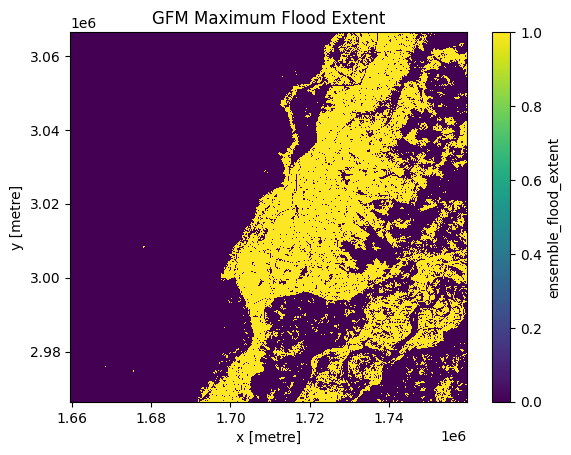

In [8]:
plt.figure()
computed_result[:5000, :5000].plot()
plt.title("GFM Maximum Flood Extent")
plt.show()

## Shutdown cluster

After successful processing, we need to shutdown our cluster to free up
resources. 

In [9]:
# After a restart of the Jupyter kernel, the cluster object is gone. Use the
# following command to connect to the cluster again
# cluster = gateway.connect(gateway.list_clusters()[0].name)

# Shutdown cluster
cluster.shutdown()